# 机器视觉 实验6-深度卷积神经网络-图像分类

**本地运行提示：**

- 默认安装`torch`、`torchvision`的CPU版本。如需使用GPU版本，需要先卸载（`pip uninstall torch torchvision`）并在[PyTorch官网](https://pytorch.org/get-started/locally/)上选择适合的架构重新安装。
    > **提示：** 将 https://download.pytorch.org/whl 替换为 https://mirrors.aliyun.com/pytorch-wheels 以使用阿里云镜像。
- 由于`torchvision.datasets`的下载是线程不安全的，因此默认不会自动下载数据集。运行`/postBuild`下载数据集
- 考虑到Binder及CPU的运算效率，并没有使用完整的数据集。“迁移学习-CIFAR10分类”的训练集和验证集都有所缩减。

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torch import optim
import sys
import platform
from datetime import datetime
import time

In [2]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'=========== System Info ===========')
print(f'系统架构: {sys.platform}')
print(f'Python版本: {platform.python_version()}')
print(f'Python构建元数据: {sys.version}')
print(f'PyTorch版本: {torch.__version__}')
print(f'PyTorch计算平台: {torch_device}')
print(f'PyTorch的cuDNN可用性: {torch.backends.cudnn.enabled}')

=========== System Info ===========
系统架构: win32
Python版本: 3.12.0
Python构建元数据: 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:26:13) [MSC v.1935 64 bit (AMD64)]
PyTorch版本: 2.8.0+cpu
PyTorch计算平台: cpu
PyTorch的cuDNN可用性: True


## 1. MNIST手写数字识别

In [3]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 120, 5),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return nn.functional.log_softmax(x, dim=1)


model = CustomLeNet5()


model

CustomLeNet5(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [4]:
batch_size = 32

dataset_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.1307, std=0.3081)
])

train_data = MNIST(root='./datasets', train=True, transform=dataset_transform)
valid_data = MNIST(root='./datasets', train=False, transform=dataset_transform)

# 截取一部分数据集
# train_data = torch.utils.data.Subset(train_data, range(1000))
# valid_data = torch.utils.data.Subset(valid_data, range(1000))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=False)

训练集数据长度：60000
验证集数据长度：10000


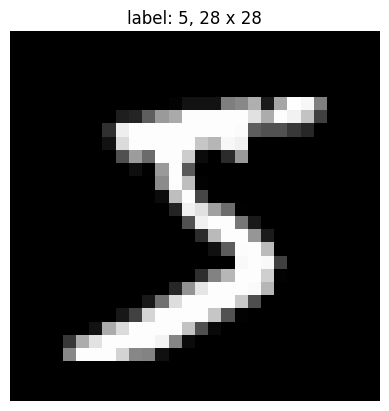

In [5]:
print(f'训练集数据长度：{len(train_data)}')
print(f'验证集数据长度：{len(valid_data)}')

plt.imshow(train_data[0][0][0, ...], cmap='gray')
plt.title(f'label: {train_data[0][1]}, {train_data[0][0].shape[2]} x {train_data[0][0].shape[1]}')
plt.axis('off')
plt.show()

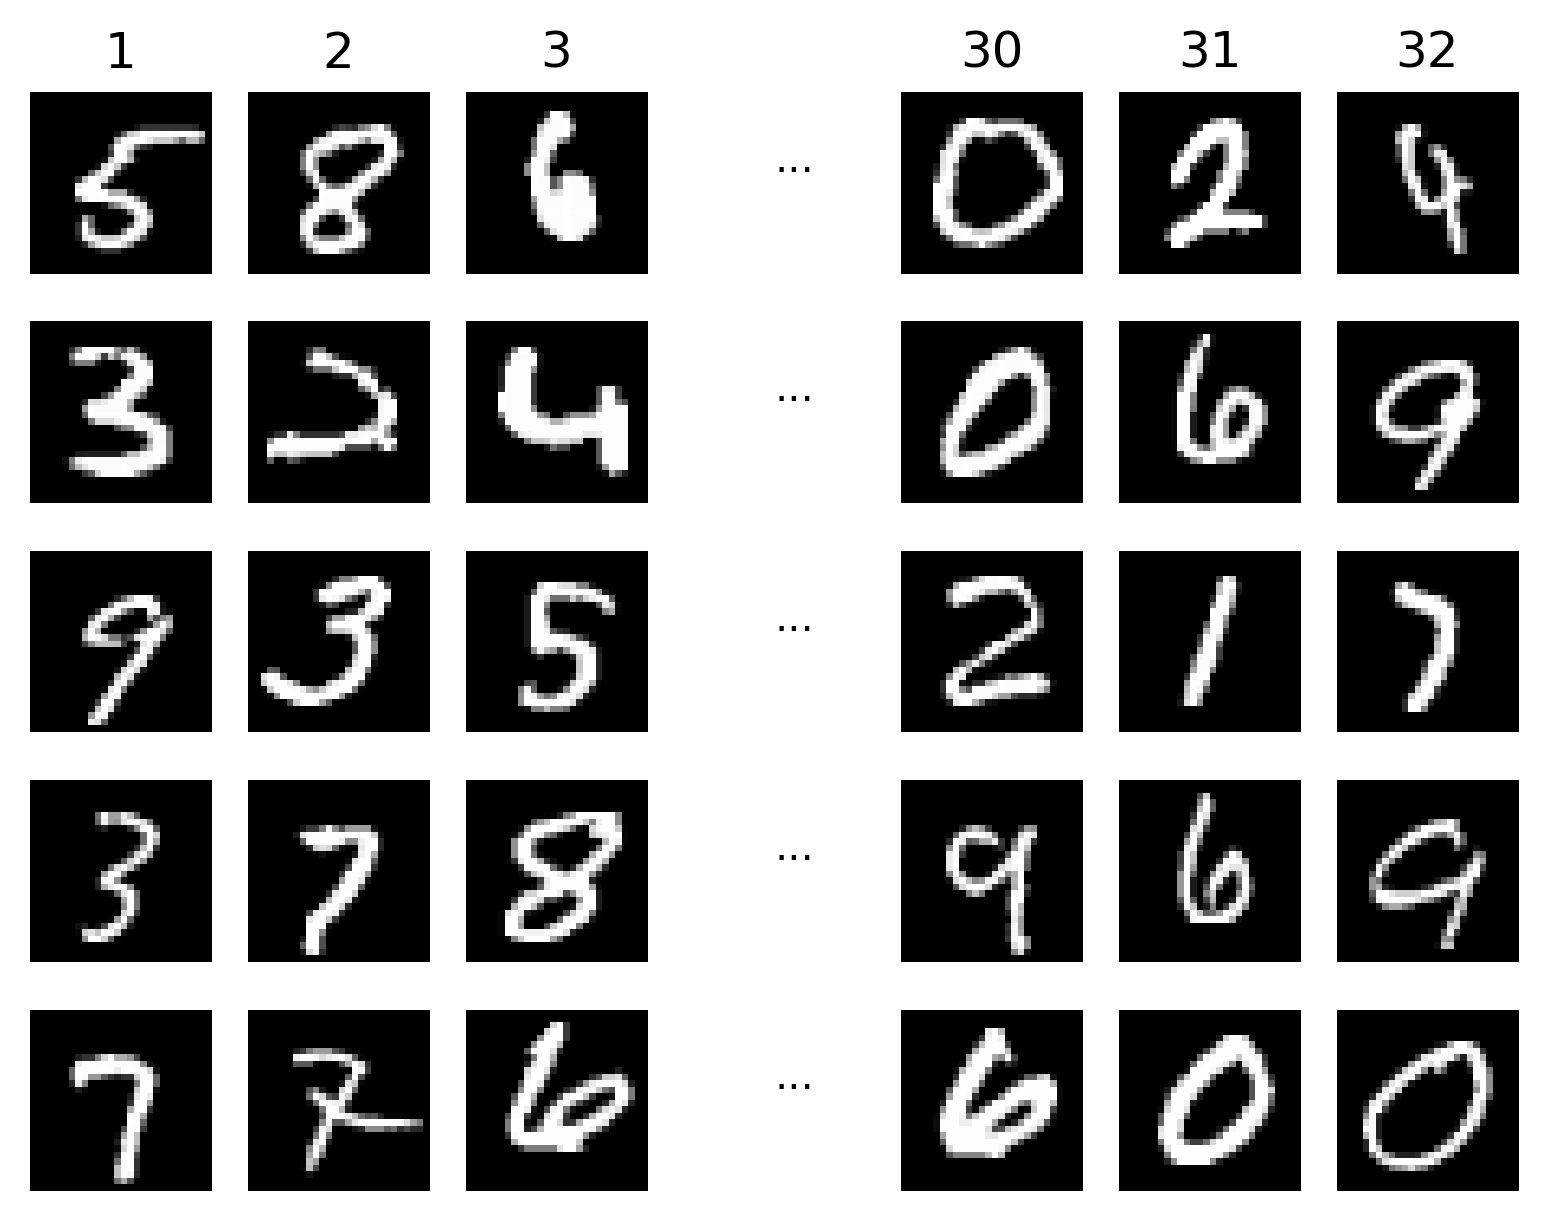

In [6]:
fig, ax = plt.subplots(5, 7, dpi=300)

for row, (inputs, targets) in enumerate(train_loader):
    if row < len(ax.squeeze()):
        [ax[row, i].imshow(inputs[i][0, ...], cmap='gray') for i in range(3)]
        ax[row, 3].annotate('···', (0.5, 0.5))
        [ax[row, i + 4].imshow(inputs[index][0, ...], cmap='gray') for i, index in enumerate(range(batch_size - 3, batch_size))]

[ax[0, i].set_title(f'{index + 1}') for i, index in enumerate(range(3))]
[ax[0, i + 4].set_title(f'{index + 1}') for i, index in enumerate(range(batch_size - 3, batch_size))]

[a.axis('off') for a in ax.flatten()]

plt.show()

In [7]:
def model_train_single_epoche(model, train_loader, loss_func, optimizer, device):

    model.train()

    epoch_losses = [0, 0]   # [sum, count]
    epoch_predicts = [0, 0] # [sum, count]
    for inputs, targets in train_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        epoch_losses[0] += loss.item()
        epoch_losses[1] += 1

        predictions = targets.detach().cpu().numpy() == outputs.detach().cpu().argmax(axis=1).numpy()
        epoch_predicts[0] += predictions.sum()
        epoch_predicts[1] += predictions.size

    return epoch_losses[0] / epoch_losses[1], epoch_predicts[0] / epoch_predicts[1]


def model_valid_single_epoche(model, valid_loader, loss_func, device):

    model.eval()

    epoch_losses = [0, 0]   # [sum, count]
    epoch_predicts = [0, 0] # [sum, count]
    for inputs, targets in valid_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        epoch_losses[0] += loss_func(outputs, targets).item()
        epoch_losses[1] += 1

        predictions = targets.detach().cpu().numpy() == outputs.detach().cpu().argmax(axis=1).numpy()
        epoch_predicts[0] += predictions.sum()
        epoch_predicts[1] += predictions.size

    return epoch_losses[0] / epoch_losses[1], epoch_predicts[0] / epoch_predicts[1]

In [8]:
loss_func = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(),
#                       lr=0.001,
#                       momentum=0.9)

optimizer = optim.AdamW(model.parameters(),
                        lr=0.01,
                        # weight_decay=0.0001,
                        betas=(0.9, 0.999))

In [9]:
epochs = 5

start_time = time.time()

accuracy_log_train = []
loss_log_train = []
accuracy_log_valid = []
loss_log_valid = []

for epoch in range(epochs):

    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;207m 训练 '
          f'\033[1;48;5;130m 训练中 '
          f'\033[0m  开始训练。')

    calculate_time = time.time()

    loss, accuracy = model_train_single_epoche(model, train_loader, loss_func, optimizer, torch_device)

    loss_log_train.append(loss)
    accuracy_log_train.append(accuracy)

    calculate_time = time.time() - calculate_time
    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;207m 训练 '
          f'\033[1;48;5;28m 完成 '
          f'\033[0m 耗时{calculate_time // 60:.0f}分{calculate_time % 60:.0f}秒。正确率约{accuracy * 100:.2f}，平均损失约{loss:.2f}。')

    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;208m 验证 '
          f'\033[1;48;5;130m 验证中 '
          f'\033[0m  正在测试集上评估。')

    loss, accuracy = model_valid_single_epoche(model, train_loader, loss_func, torch_device)

    loss_log_valid.append(loss)
    accuracy_log_valid.append(accuracy)

    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;208m 验证 '
          f'\033[1;48;5;28m 完成 '
          f'\033[0m 正确率约{accuracy * 100:.2f}，平均损失约{loss:.2f}。')


start_time = time.time() - start_time
print(f'\033[1;48;5;30m {datetime.now()} '
      f'\033[1;48;5;28m       完成         '
      f'\033[0m 耗时{start_time // 60:.0f}分{start_time % 60:.0f}秒。')

 2025-08-26 21:51:01.853972  Epoch 1  训练  训练中   开始训练。
 2025-08-26 21:51:31.193322  Epoch 1  训练  完成  耗时0分29秒。正确率约94.57，平均损失约0.19。
 2025-08-26 21:51:31.193322  Epoch 1  验证  验证中   正在测试集上评估。
 2025-08-26 21:51:40.259277  Epoch 1  验证  完成  正确率约95.24，平均损失约0.17。
 2025-08-26 21:51:40.259277  Epoch 2  训练  训练中   开始训练。
 2025-08-26 21:52:03.954597  Epoch 2  训练  完成  耗时0分24秒。正确率约96.55，平均损失约0.14。
 2025-08-26 21:52:03.954597  Epoch 2  验证  验证中   正在测试集上评估。
 2025-08-26 21:52:13.541930  Epoch 2  验证  完成  正确率约97.67，平均损失约0.09。
 2025-08-26 21:52:13.542437  Epoch 3  训练  训练中   开始训练。
 2025-08-26 21:52:43.209087  Epoch 3  训练  完成  耗时0分30秒。正确率约96.97，平均损失约0.13。
 2025-08-26 21:52:43.209087  Epoch 3  验证  验证中   正在测试集上评估。
 2025-08-26 21:53:08.157247  Epoch 3  验证  完成  正确率约97.20，平均损失约0.11。
 2025-08-26 21:53:08.158248  Epoch 4  训练  训练中   开始训练。
 2025-08-26 21:54:05.202826  Epoch 4  训练  完成  耗时0分57秒。正确率约97.33，平均损失约0.11。
 2025-08-26 21:54:05.202826  Epoch 4  验证  验证中   正在测试集上评估。
 2025-08-26 21:54:14.821347  Epoch 4  验证  完成  正确率约9

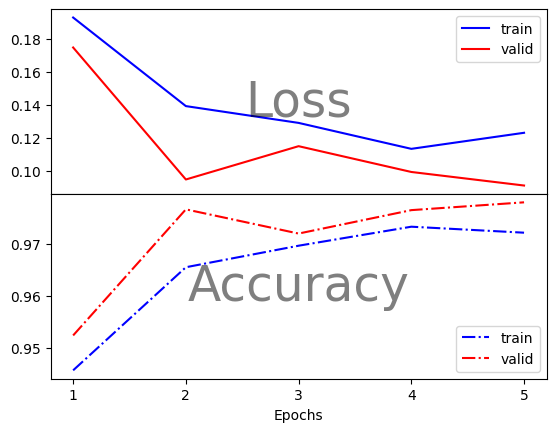

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

x_tick = np.arange(1, epochs + 1)

axs[0].plot(x_tick, loss_log_train, 'b', label='train')
axs[0].plot(x_tick, loss_log_valid, 'r', label='valid')
axs[0].set_xticks(x_tick)
axs[0].text(0.5, 0.5, "Loss", transform=axs[0].transAxes,
            ha='center', va='center', fontsize=35, alpha=.5)
axs[0].legend(loc='upper right')

axs[1].plot(x_tick, accuracy_log_train, '-.b', label='train')
axs[1].plot(x_tick, accuracy_log_valid, '-.r', label='valid')
axs[1].set_xticks(x_tick)
axs[1].text(0.5, 0.5, "Accuracy", transform=axs[1].transAxes,
            ha='center', va='center', fontsize=35, alpha=.5)
axs[1].legend(loc='lower right')

plt.xlabel('Epochs')

plt.show()

## 2. 迁移学习-CIFAR10分类

In [11]:
# 'pretrained' have been deprecated since 0.13
# model = torchvision.models.resnet18(pretrained=True)
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

# model.add_module('log_softmax', nn.LogSoftmax(dim=1))


model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
batch_size = 32

dataset_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5537, 0.4122, 0.2511],
                         std=[0.1595, 0.1665, 0.1603])
])

train_data = CIFAR10(root='./datasets', train=True, transform=dataset_transform)
valid_data = CIFAR10(root='./datasets', train=False, transform=dataset_transform)

# 截取一部分数据集
train_data = torch.utils.data.Subset(train_data, range(3125))
valid_data = torch.utils.data.Subset(valid_data, range(625))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=False)

训练集数据长度：3125
验证集数据长度：625


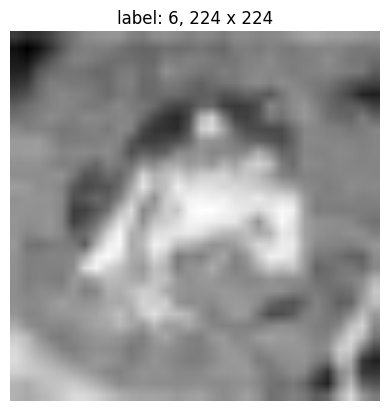

In [13]:
print(f'训练集数据长度：{len(train_data)}')
print(f'验证集数据长度：{len(valid_data)}')

plt.imshow(train_data[0][0][0, ...], cmap='gray')
plt.title(f'label: {train_data[0][1]}, {train_data[0][0].shape[2]} x {train_data[0][0].shape[1]}')
plt.axis('off')
plt.show()

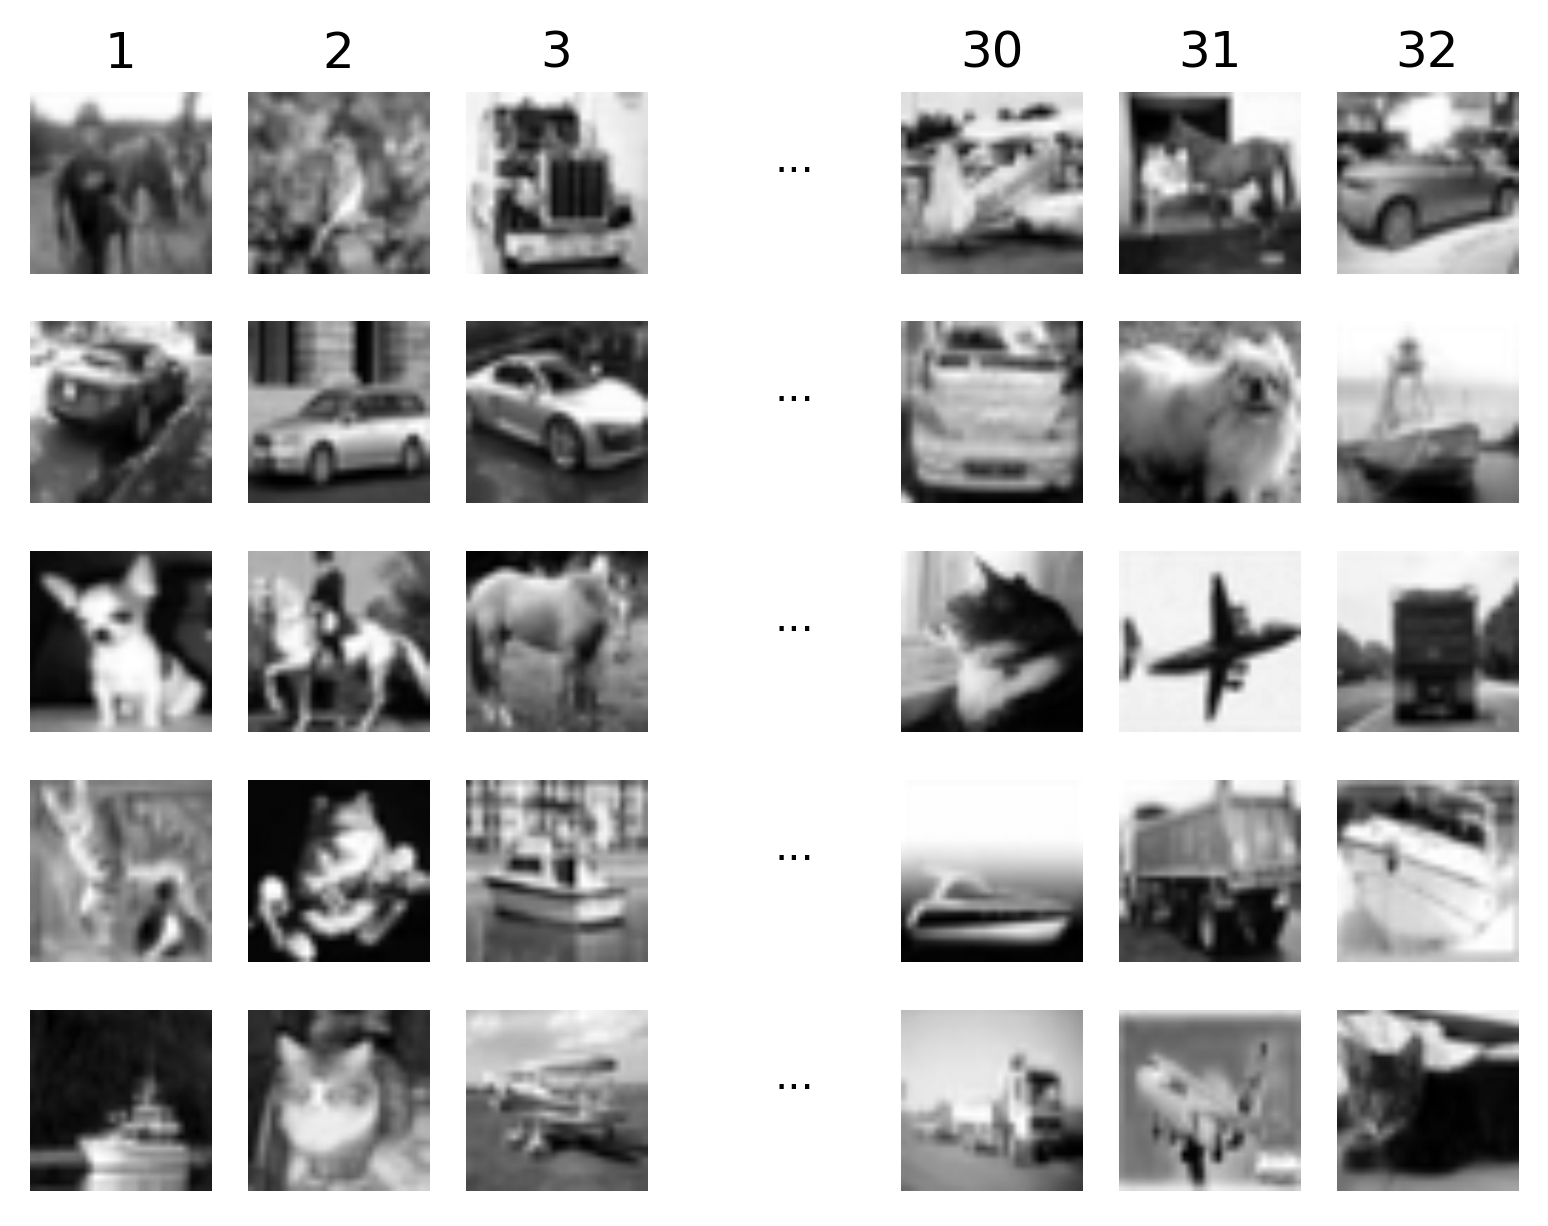

In [14]:
fig, ax = plt.subplots(5, 7, dpi=300)

for row, (inputs, targets) in enumerate(train_loader):
    if row < len(ax.squeeze()):
        [ax[row, i].imshow(inputs[i][0, ...], cmap='gray') for i in range(3)]
        ax[row, 3].annotate('···', (0.5, 0.5))
        [ax[row, i + 4].imshow(inputs[index][0, ...], cmap='gray') for i, index in enumerate(range(batch_size - 3, batch_size))]

[ax[0, i].set_title(f'{index + 1}') for i, index in enumerate(range(3))]
[ax[0, i + 4].set_title(f'{index + 1}') for i, index in enumerate(range(batch_size - 3, batch_size))]

[a.axis('off') for a in ax.flatten()]

plt.show()

In [15]:
loss_func = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(),
#                       lr=0.001,
#                       momentum=0.9,
#                       weight_decay=0.01)

optimizer = optim.AdamW(model.parameters(),
                        lr=0.01,
                        betas=(0.9, 0.999)) #, weight_decay=0.9)

In [16]:
epochs = 5

start_time = time.time()

accuracy_log_train = []
loss_log_train = []
accuracy_log_valid = []
loss_log_valid = []

for epoch in range(epochs):

    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;207m 训练 '
          f'\033[1;48;5;130m 训练中 '
          f'\033[0m  开始训练。')

    calculate_time = time.time()

    loss, accuracy = model_train_single_epoche(model, train_loader, loss_func, optimizer, torch_device)

    loss_log_train.append(loss)
    accuracy_log_train.append(accuracy)

    calculate_time = time.time() - calculate_time
    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;207m 训练 '
          f'\033[1;48;5;28m 完成 '
          f'\033[0m 耗时{calculate_time // 60:.0f}分{calculate_time % 60:.0f}秒。正确率约{accuracy * 100:.2f}，平均损失约{loss:.2f}。')

    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;208m 验证 '
          f'\033[1;48;5;130m 验证中 '
          f'\033[0m  正在测试集上评估。')

    loss, accuracy = model_valid_single_epoche(model, train_loader, loss_func, torch_device)

    loss_log_valid.append(loss)
    accuracy_log_valid.append(accuracy)

    print(f'\033[1;48;5;30m {datetime.now()} '
          f'\033[1;48;5;141m Epoch {epoch + 1} '
          f'\033[1;48;5;208m 验证 '
          f'\033[1;48;5;28m 完成 '
          f'\033[0m 正确率约{accuracy * 100:.2f}，平均损失约{loss:.2f}。')


start_time = time.time() - start_time
print(f'\033[1;48;5;30m {datetime.now()} '
      f'\033[1;48;5;28m       完成         '
      f'\033[0m 耗时{start_time // 60:.0f}分{start_time % 60:.0f}秒。')

 2025-08-26 21:54:51.676115  Epoch 1  训练  训练中   开始训练。
 2025-08-26 21:55:34.625748  Epoch 1  训练  完成  耗时0分43秒。正确率约58.47，平均损失约1.32。
 2025-08-26 21:55:34.625748  Epoch 1  验证  验证中   正在测试集上评估。
 2025-08-26 21:56:38.449694  Epoch 1  验证  完成  正确率约78.70，平均损失约0.63。
 2025-08-26 21:56:38.449694  Epoch 2  训练  训练中   开始训练。
 2025-08-26 21:57:28.589868  Epoch 2  训练  完成  耗时0分50秒。正确率约73.03，平均损失约0.80。
 2025-08-26 21:57:28.589868  Epoch 2  验证  验证中   正在测试集上评估。
 2025-08-26 21:58:08.380431  Epoch 2  验证  完成  正确率约80.80，平均损失约0.56。
 2025-08-26 21:58:08.380431  Epoch 3  训练  训练中   开始训练。
 2025-08-26 21:58:52.084267  Epoch 3  训练  完成  耗时0分44秒。正确率约75.32，平均损失约0.78。
 2025-08-26 21:58:52.084267  Epoch 3  验证  验证中   正在测试集上评估。
 2025-08-26 21:59:31.135544  Epoch 3  验证  完成  正确率约78.93，平均损失约0.64。
 2025-08-26 21:59:31.135544  Epoch 4  训练  训练中   开始训练。
 2025-08-26 22:00:26.997786  Epoch 4  训练  完成  耗时0分56秒。正确率约75.52，平均损失约0.78。
 2025-08-26 22:00:26.997786  Epoch 4  验证  验证中   正在测试集上评估。
 2025-08-26 22:01:07.345235  Epoch 4  验证  完成  正确率约8

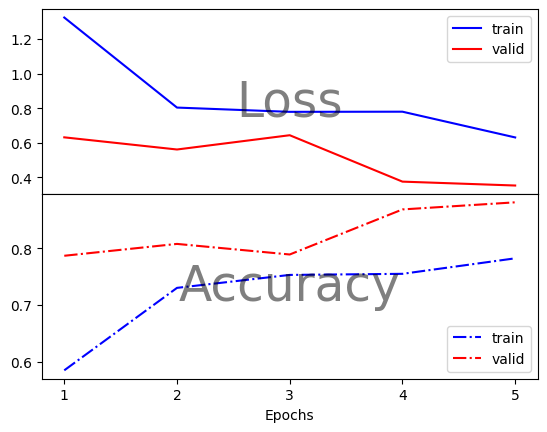

In [17]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

x_tick = np.arange(1, epochs + 1)

axs[0].plot(x_tick, loss_log_train, 'b', label='train')
axs[0].plot(x_tick, loss_log_valid, 'r', label='valid')
axs[0].set_xticks(x_tick)
axs[0].text(0.5, 0.5, "Loss", transform=axs[0].transAxes,
            ha='center', va='center', fontsize=35, alpha=.5)
axs[0].legend(loc='upper right')

axs[1].plot(x_tick, accuracy_log_train, '-.b', label='train')
axs[1].plot(x_tick, accuracy_log_valid, '-.r', label='valid')
axs[1].set_xticks(x_tick)
axs[1].text(0.5, 0.5, "Accuracy", transform=axs[1].transAxes,
            ha='center', va='center', fontsize=35, alpha=.5)
axs[1].legend(loc='lower right')

plt.xlabel('Epochs')

plt.show()